In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit

In [2]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [3]:
mapper = JordanWignerMapper()

In [119]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-0.67815051 * IIII
+0.04035523 * IIIZ
+0.03892110 * IIZI
+0.03307331 * IIZZ
+0.04035523 * IZII
+0.11320163 * IZIZ
+0.11336252 * IZZI
+0.08028921 * XXXX
+0.08028921 * XXYY
+0.08028921 * YYXX
+0.08028921 * YYYY
+0.03892110 * ZIII
+0.11336252 * ZIIZ
+0.11352456 * ZIZI
+0.03307331 * ZZII


In [60]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [104]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e4, 10e4, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e4, 10e4, 4)  # Sampled from normal distribution mean 50 microsec

print(T1s, T2s)

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

print(T2s)

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

[399791.13642129 514556.77756607 472788.85761026 486536.99511965] [473001.9874462  773552.60979178 733757.01839065 773383.38325404]
[473001.9874462  773552.60979178 733757.01839065 773383.38325404]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'measure', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


In [105]:
seed = 69

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_thermal,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

# noisy x = 0.99X + 0.01I

In [106]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(noisy_estimator, ansatz, L_BFGS_B())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

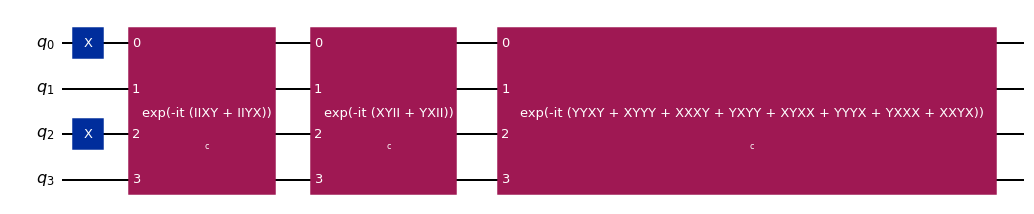

In [7]:
circuit = QuantumCircuit(4)
circuit.compose(ansatz.initial_state, inplace=True)
for block in ansatz._entanglement_blocks:
  circuit.compose(block, inplace=True)
circuit.draw(output="mpl")

In [8]:
for excitation in ansatz._excitation_list:
    print(f"{excitation[0]} => {excitation[1]}")

(0,) => (1,)
(2,) => (3,)
(0, 2) => (1, 3)


In [44]:
from qiskit.synthesis import qs_decomposition
unitary = ansatz.operators[0]
# circ.draw('mpl')
unitary

SparsePauliOp(['IIXY', 'IIYX'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

In [41]:
from qiskit.quantum_info import Pauli

# Define the Pauli matrices
I = Pauli("I")
X = Pauli("X")
Y = Pauli("Y")

# Compute the tensor product
p1 = I.tensor(I).tensor(X).tensor(Y).to_matrix()
p2 = I.tensor(I).tensor(Y).tensor(X).to_matrix()
p3 = (p1 - p2) / 2
p3 == unitary.to_matrix()

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  Tru

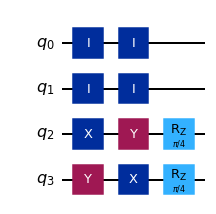

In [51]:
from qiskit import QuantumCircuit

# Define the combined operator 0.5 * (IIXY - IIYX)
combined_operator = unitary
# Create a quantum circuit for a 4-qubit system
qc = QuantumCircuit(4)
qc.id(0)
qc.id(1)
qc.x(2)
qc.y(3)

# Apply the IIYX part with a negative sign
qc.id(0)
qc.id(1)
qc.y(2)
qc.x(3)

# Apply the 0.5 coefficient
theta = np.pi / 4  # equivalent to the sqrt of the coefficient 0.5 in terms of phase
qc.rz(theta, 2)
qc.rz(theta, 3)
# qc.measure_all()
qc.draw(output="mpl")

In [128]:
from qiskit_nature.second_q.problems import EigenstateResult

raw_result = (vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op))
res = es_problem.interpret(EigenstateResult.from_result(raw_result))
res.total_energies[0]

-0.6206130504615697

In [126]:
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(es_problem)
# print(res)

In [129]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.6206130504615697
Actual Energy: -0.6148699740425608
Percentage Error: 0.93%


In [109]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    res = calc.solve(es_problem)
    vqe_energies.append(res.eigenvalues[0] + res._nuclear_repulsion_energy)

Calculating energies: 100%|██████████| 37/37 [00:05<00:00,  6.84it/s]


In [110]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

interpolated_function = interp1d(distances, vqe_energies, kind='cubic')
result = minimize_scalar(interpolated_function, bounds=(distances.min(), distances.max()), method='bounded')

min_distance = result.x
min_energy = result.fun
print(f"The distance that minimizes the energy is: {min_distance} Å")
print(f"The minimum energy is: {min_energy} Hartree")
# -0.98 hartree minimum energy for noisy
# -1.11 for noiseless

The distance that minimizes the energy is: 0.7302392105582309 Å
The minimum energy is: -1.096536892803767 Hartree


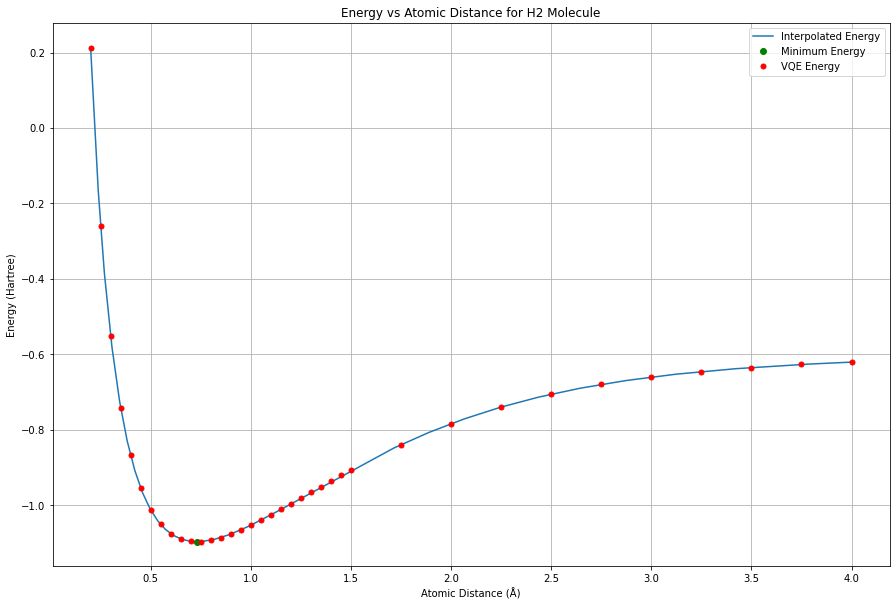

In [111]:
fine_distances = np.linspace(distances.min(), distances.max(), 500)
interpolated_energies = interpolated_function(fine_distances)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(fine_distances, interpolated_energies, label='Interpolated Energy')
plt.plot(min_distance, min_energy, 'go', label='Minimum Energy')
plt.plot(distances, vqe_energies, marker='o', color='red', linestyle='', markersize=5, label='VQE Energy')
plt.xlabel('Atomic Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs Atomic Distance for H2 Molecule')
plt.grid(True)
plt.legend()
plt.show()